In [1]:
import os
import numpy as np
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn import metrics

In [2]:
# Define the file name
filename = 'GW3_Transformer.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bkg_train = np.array(file['bkg_train'])
    bkg_test = np.array(file['bkg_test'])
    signal_train = np.array(file['signal_train'])
    signal_test = np.array(file['signal_test'])

In [3]:
anomaly_class = {
    'bkg': 0,
    'signal': 1
}

bkg_train_ids = np.full(bkg_train.shape[0], anomaly_class['bkg'], dtype=int)
bkg_test_ids = np.full(bkg_test.shape[0], anomaly_class['bkg'], dtype=int)

signal_train_ids = np.full(signal_train.shape[0], anomaly_class['signal'], dtype=int)
signal_test_ids = np.full(signal_test.shape[0], anomaly_class['signal'], dtype=int)

In [4]:
x_train = np.concatenate((bkg_train, signal_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((bkg_train_ids, signal_train_ids), axis=0)

x_test = np.concatenate((bkg_test, signal_test), axis=0).transpose((0,2,1))
y_test = np.concatenate((bkg_test_ids, signal_test_ids), axis=0)

In [5]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [6]:
print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')
# print(f'Number of classes: {n_classes}')

x train/test shapes: (124137, 100, 2) (21908, 100, 2)
y train/test shapes: (124137,) (21908,)


In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    res = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Part
    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.Add()([x, res])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

In [10]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.2,
    mlp_dropout=0.2,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Dense(ff_dim)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.Dense(1, activation="relu")(x)
    x = layers.Flatten()(x)
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [15]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=32,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[8],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy"],
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 2)]     0           []                               
                                                                                                  
 dense_42 (Dense)               (None, 100, 4)       12          ['input_6[0][0]']                
                                                                                                  
 layer_normalization_25 (LayerN  (None, 100, 4)      8           ['dense_42[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_10 (Multi  (None, 100, 4)      1220        ['layer_normalization_25[0]

In [16]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/100
97/97 [==============================] - 14s 35ms/step - loss: 0.7673 - binary_accuracy: 0.5072 - val_loss: 0.6992 - val_binary_accuracy: 0.5251
Epoch 2/100
97/97 [==============================] - 3s 35ms/step - loss: 0.7073 - binary_accuracy: 0.5088 - val_loss: 0.6788 - val_binary_accuracy: 0.5454
Epoch 3/100
97/97 [==============================] - 3s 33ms/step - loss: 0.6852 - binary_accuracy: 0.5261 - val_loss: 0.6554 - val_binary_accuracy: 0.6268
Epoch 4/100
97/97 [==============================] - 3s 33ms/step - loss: 0.6559 - binary_accuracy: 0.5572 - val_loss: 0.5869 - val_binary_accuracy: 0.8787
Epoch 5/100
97/97 [==============================] - 3s 33ms/step - loss: 0.5834 - binary_accuracy: 0.6095 - val_loss: 0.4680 - val_binary_accuracy: 0.9277
Epoch 6/100
97/97 [==============================] - 3s 32ms/step - loss: 0.4864 - binary_accuracy: 0.6986 - val_loss: 0.3934 - val_binary_accuracy: 0.9328
Epoch 7/100
97/97 [==============================] - 3s 32ms/st

[0.12133269011974335, 0.9635749459266663]

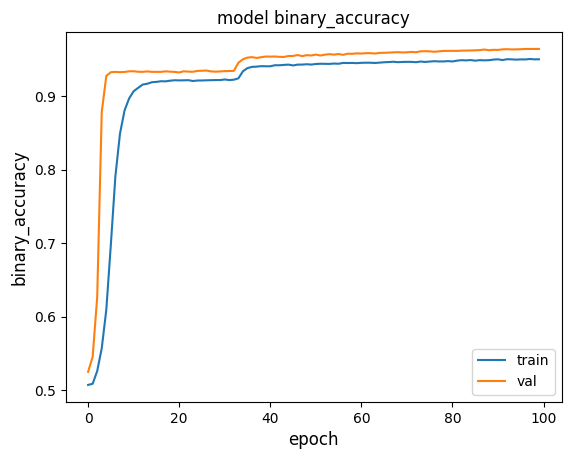

In [17]:
metric = "binary_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

685/685 [==============================] - 2s 2ms/step
The total AUC is 97.8 %


Text(0, 0.5, 'TPR')

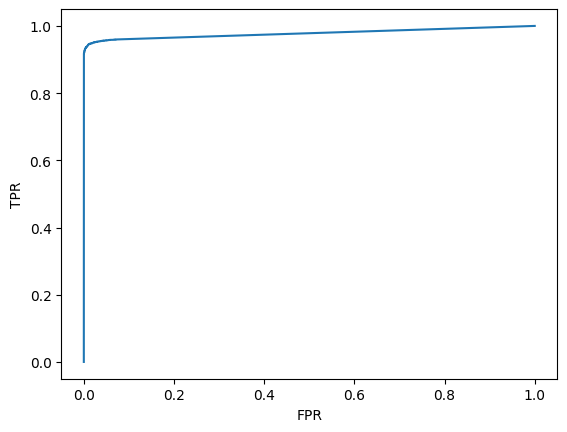

In [18]:
from sklearn import metrics
scores = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
auc = metrics.roc_auc_score(y_test, scores)
print(f'The total AUC is {auc*100:.1f} %')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [19]:
# model.save("LIGO_transformer_based_classifier_v4.h5")

In [20]:
from tensorflow.keras.models import load_model
model = load_model('LIGO_transformer_based_classifier_v4.h5')

In [21]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 2)]     0           []                               
                                                                                                  
 dense_42 (Dense)               (None, 100, 4)       12          ['input_6[0][0]']                
                                                                                                  
 layer_normalization_25 (LayerN  (None, 100, 4)      8           ['dense_42[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_10 (Multi  (None, 100, 4)      1220        ['layer_normalization_25[0]